In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### 随机向量的夹角分布

高维空间下两个随机随机向量大概率是正交的。推导见 https://kexue.fm/archives/7076

In [2]:
def truncated_normal(mean, std, shape, a=None, b=None):
  a = -(mean+2*std) if a is None else a
  b = mean+2*std if b is None else b
  x = []
  size = np.prod(shape)
  while True:
    s = np.random.normal(mean, std, size)
    x += list(s[np.where((s>a)*(s<b))[0]])
    if len(x) == np.prod(shape):
      return np.reshape(np.array(x), shape)
    size = np.prod(shape) - len(x)

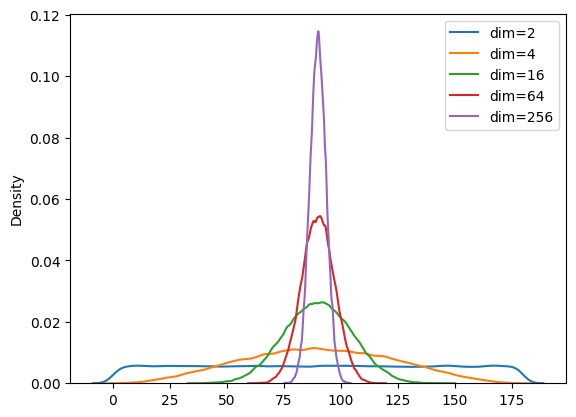

In [3]:
N = 50000

for d in (2, 4, 16, 64, 256):
  a = np.random.normal(0, 1, (N, d))
  b = np.random.normal(0, 1, (N, d))
  thetas = (a*b).sum(1) / (((a**2).sum(1)**0.5) * ((b**2).sum(1)**0.5))
  thetas = np.arccos(thetas) / np.pi * 180
  sns.kdeplot(thetas, bw_adjust=0.5, label=f"dim={d}")
plt.legend()
plt.show()

### 矩阵乘法的方差分析

#### 正态分布
- 假设 $W \sim \mathcal{N}(0, \sigma_1^2), X \sim \mathcal{N}(0, \sigma_2^2)$，每行 W 和每列 X 的维度均为 K，$Y=WX$ 的方差是多少？
- W 某一行和 X 某一列 element-wise 相乘，然后加和得到 y
- 首先考虑 element-wise 点乘后的方差
  - $Var(wx)=E((wx)^2) - E(wx)^2$
  - 第一项：w 和 x 独立，则 $E((wx)^2)=E(w^2)E(x^2)$，由于均值为0，因此 $E(w^2)E(x^2)=Var(w)Var(e)$
  - 第二项：由于 w 和 x 独立且各自均值均为 0，因此 $E(wx)^2=0$ 
  - $Var(wx)=Var(w)Var(x)$
- 点乘后 k 个元素相加得到 y，由于 k 个元素相互独立，则 $Var(y)=\sum_{i=1}^{K} Var(wx_{i})$

In [4]:
x = np.random.normal(0, 0.1, (1000, 1000))
w = np.random.normal(0, 0.1, (1000, 1000))

print(f"variance of elemwise product: {(0.1**2)*(0.1)**2:.6f}, actual: {(x*w).var():.6f}")
print(f"variance of matmul: {(0.1**2)*(0.1)**2 * 1000:.6f}, actual: {(x@w).var():.6f}")

variance of elemwise product: 0.000100, actual: 0.000100
variance of matmul: 0.100000, actual: 0.100318


#### [截断正态分布 (Truncated normal distribution)](https://en.wikipedia.org/wiki/Truncated_normal_distribution)

In [5]:
def truncated_normal(mean, std, shape, a=None, b=None):
  a = -(mean+2*std) if a is None else a
  b = mean+2*std if b is None else b
  x = []
  size = np.prod(shape)
  while True:
    s = np.random.normal(mean, std, size)
    x += list(s[np.where((s>a)*(s<b))[0]])
    if len(x) == np.prod(shape):
      return np.reshape(np.array(x), shape)
    size = np.prod(shape) - len(x)
    
import statistics

def truncated_normal_stat(mu, sigma, a=None, b=None):
  """calculate mean and std for a truncated normal distribution"""
  a = -(mu+2*sigma) if a is None else a
  b = mu+2*sigma if b is None else b
  alpha, beta = (a-mu)/sigma, (b-mu)/sigma
  norm = statistics.NormalDist(mu=0, sigma=1)
  d1 = norm.pdf(beta) - norm.pdf(alpha)
  d2 = norm.cdf(beta) - norm.cdf(alpha)
  mu_t = mu - sigma * d1 / d2
  sigma_t = (sigma**2 * (1 - (beta*norm.pdf(beta)-alpha*norm.pdf(alpha))/d2 - (d1/d2)**2)) ** 0.5
  return mu_t, sigma_t

mu, sigma = 0, 0.1
x = truncated_normal(mu, sigma, (1000, 1000))
w = truncated_normal(mu, sigma, (1000, 1000))

mu_x, sigma_x = truncated_normal_stat(mu, sigma)
mu_w, sigma_w = truncated_normal_stat(mu, sigma)
#print(f"mean: {mu_x:.6f}, actual: {x.mean():.6f}")
#print(f"std: {sigma_x:.6f}, actual: {x.std():.6f}")

print(f"variance of elemwise product: {sigma_x**2 * sigma_w**2:.6f}, actual: {(x*w).var():.6f}")
print(f"variance of matmul: {(sigma_x**2 * sigma_w**2) * 1000:.6f}, actual: {(x@w).var():.6f}")

variance of elemwise product: 0.000060, actual: 0.000060
variance of matmul: 0.059868, actual: 0.060012


### 网络中不同的初方法

核心是**希望上层输入经过网络层后，输出的方差能够尽可能保持不变**。如果方差发生变化，那么多层的叠加会使最后输出的方差巨大或为0，由于输出最后会乘到梯度上，进而会导致训练不稳定。

从上面的推导可知对于矩阵乘法，均值为 0 的矩阵 W 和矩阵 X 相乘输出 Y 的方差为 $\sigma_y^2=K\sigma_w^2 \sigma_x^2$，为了让输出 Y 的方差保持和输入相等，则 $\sigma_w^2=\frac{1}{K}, \sigma_w=\frac{1}{\sqrt{K}}$

网络层通常包含矩阵乘法和激活函数，不同的激活函数对输出会有不同的影响，因此在没有显式对输入做归一化的情况下，需要根据不同的激活函数考虑不同的参数初始化策略



In [10]:
def leaky_relu(x, alpha=0.01): return np.maximum(x, 0) + np.minimum(0, x) * alpha
def relu(x): return leaky_relu(x, 0)
def tanh(x): return np.tanh(x)
def sigmoid(x): return 1/(1+np.exp(-x))

def he_init(shape): return np.random.normal(0, (2/shape[0])**0.5, shape)
def xavier_init(shape): return np.random.normal(0, (1/shape[0])**0.5, shape)
def normal_init(shape): return np.random.normal(0, 1, shape)

N = 1024
L = 50
mean, std = 0, 0.1

print("--- Tanh + Xavier ---")
x = np.random.normal(mean, std, (N, N))
print(f"std init: {x.std()}")
for i in range(L):
  x = tanh(xavier_init((N, N)) @ x)
print(f"std after {L} layers: {x.std()}")

print("--- Tanh + Xavier optimized ---")
x = np.random.normal(mean, std, (N, N))
print(f"std init: {x.std()}")
for i in range(L):
  x = tanh((xavier_init((N, N)) * (1/0.395)**2) @ x)
print(f"std after {L} layers: {x.std()}")

print("--- ReLU + Xavier ---")
x = np.random.normal(mean, std, (N, N))
print(f"std init: {x.std()}")
for i in range(L):
  x = relu(xavier_init((N, N)) @ x)
print(f"std after {L} layers: {x.std()}")

print("--- ReLU + HeInit ---")
x = np.random.normal(mean, std, (N, N))
print(f"std init: {x.std()}")
for i in range(L):
  x = relu(he_init((N, N)) @ x)
print(f"std after {L} layers: {x.std()}")

print("--- Leaky ReLU + HeInit ---")
x = np.random.normal(mean, std, (N, N))
print(f"std init: {x.std()}")
for i in range(L):
  x = leaky_relu(he_init((N, N)) @ x)
print(f"std after {L} layers: {x.std()}")

--- Tanh + Xavier ---
std init: 0.10015359327852073
std after 50 layers: 0.0670640635771099
--- Tanh + Xavier optimized ---
std init: 0.09997152877859207
std after 50 layers: 0.9317893562302493
--- ReLU + Xavier ---
std init: 0.10002990268571155
std after 50 layers: 1.7037872244711263e-09
--- ReLU + HeInit ---
std init: 0.09991813241593779
std after 50 layers: 0.0656703061423435
--- Leaky ReLU + HeInit ---
std init: 0.1000800407706275
std after 50 layers: 0.08808995534058658


### Dropout 

网络层可能给带有 dropout。即对输出按照一定概率 p 随机 mask 掉一部分，然后对剩余的值进行放缩 v /= (1-p)。以下讨论 dropout 对于输出的影响。

- 对均值无影响，因为会对非 mask 的元素进行放缩
- 方差变为原来的 $\frac{1}{1-p}$ 倍，标准差为原来 $\sqrt{\frac{1}{1-p}}$

In [11]:
def dropout(x, p=0.1):
  mask = np.random.uniform(0, 1, x.shape) < p
  x[mask] = 0
  x[~mask] /= 1-p
  return x

a = np.random.normal(0, 1, 100000)
print("before: ", a.std())
print("after(actual): ", dropout(a, p=0.2).std())
print("after: ", (1/(1-0.2))**0.5)

before:  0.9996269109221873
after(actual):  1.116535614020017
after:  1.118033988749895


In [12]:
N = 1024
L = 10
  
print("--- Leaky ReLU + HeInit + Dropout ---")
x = np.random.normal(0, 0.1, (N, N))
print(f"std init: {x.std()}")
for i in range(L):
  x = leaky_relu(he_init((N, N)) @ x)
  x = dropout(x, p=0.1) * (1-0.1)**0.5
print(f"std after {L} layers: {x.std()}")

--- Leaky ReLU + HeInit + Dropout ---
std init: 0.09999280968268731
std after 10 layers: 0.08558545140567198


### 显式归一化

无论是 LayerNorm 或者 BatchNorm 都是对输入进行显式的归一化

In [13]:
def layer_norm(x):
  return (x - x.mean(-1, keepdims=True)) / (x.var(-1, keepdims=True) + 1e-6)**0.5
  
N = 1024
L = 10

stds1, stds2, stds3 = [], [], []
print("--- Leaky ReLU + NormInit ---")
x = np.random.normal(0, 0.1, (N, N))
print(f"std init: {x.std()}")
for i in range(L):
  x = leaky_relu(normal_init((N, N)) @ x)
  stds1.append(x.std())
print(f"std after {L} layers: {x.std()}")

print("--- Leaky ReLU + NormInit + (pre) LayerNorm ---")
x = np.random.normal(0, 0.1, (N, N))
print(f"std init: {x.std()}")
for i in range(L):
  x = layer_norm(x)
  x = leaky_relu(normal_init((N, N)) @ x)
  stds2.append(x.std())
print(f"std after {L} layers: {x.std()}")

print("--- Leaky ReLU + NormInit + (post) LayerNorm ---")
x = np.random.normal(0, 0.1, (N, N))
print(f"std init: {x.std()}")
for i in range(L):
  x = leaky_relu(normal_init((N, N)) @ x)
  x = layer_norm(x)
  stds3.append(x.std())
print(f"std after {L} layers: {x.std()}")

print("--- Leaky ReLU + NormInit + (pre) LayerNorm ---")
x = np.random.normal(0, 0.1, (N, N))
print(f"std init: {x.std()}")
for i in range(L):
  x = layer_norm(x)
  x = leaky_relu(he_init((N, N)) @ x)
print(f"std after {L} layers: {x.std()}")

--- Leaky ReLU + NormInit ---
std init: 0.09991707167135482
std after 10 layers: 2687538766691.2817
--- Leaky ReLU + NormInit + (pre) LayerNorm ---
std init: 0.09986163596850768
std after 10 layers: 18.82321909318204
--- Leaky ReLU + NormInit + (post) LayerNorm ---
std init: 0.09999715210437857
std after 10 layers: 0.9999999985800573
--- Leaky ReLU + NormInit + (pre) LayerNorm ---
std init: 0.09992644531745395
std after 10 layers: 0.8311617484319603
